In [1]:
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np 
import random
import seaborn as sns
import warnings
import time
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy import stats

warnings.filterwarnings("ignore")

In [2]:
seed = 101

In [3]:
featureNames = ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
df = pd.read_csv(r'train_2v.csv', header=0)

In [4]:
df.describe()

,id,age,avg_glucose_level,bmi
count,43400.000000,43400.000000,43400.000000,41938.000000
mean,36326.142350,42.217894,104.482750,28.605038
std,21072.134879,22.519649,43.111751,7.770020
min,1.000000,0.080000,55.000000,10.100000
25%,18038.500000,24.000000,77.540000,23.200000
50%,36351.500000,44.000000,91.580000,27.700000
75%,54514.250000,60.000000,112.070000,32.900000
max,72943.000000,82.000000,291.050000,97.600000


Text(0.5, 1.0, 'Class Frequency\n0 : no stroke\n1: stroke')

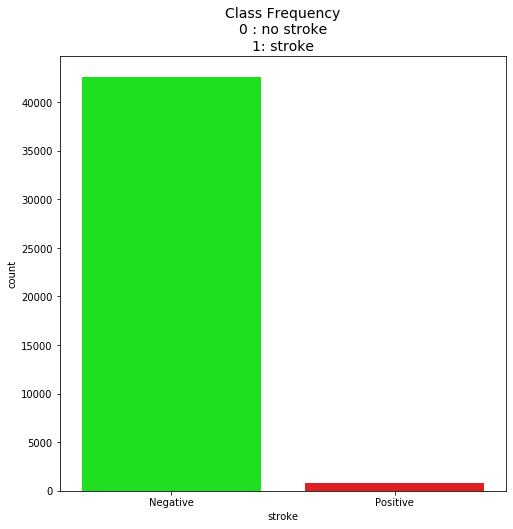

In [5]:
colors = ["#00FF00", "#FF0000"]
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot('stroke', data=df, ax=ax, palette=colors)
plt.title('Class Frequency\n0 : no stroke\n1: stroke', fontsize=14)


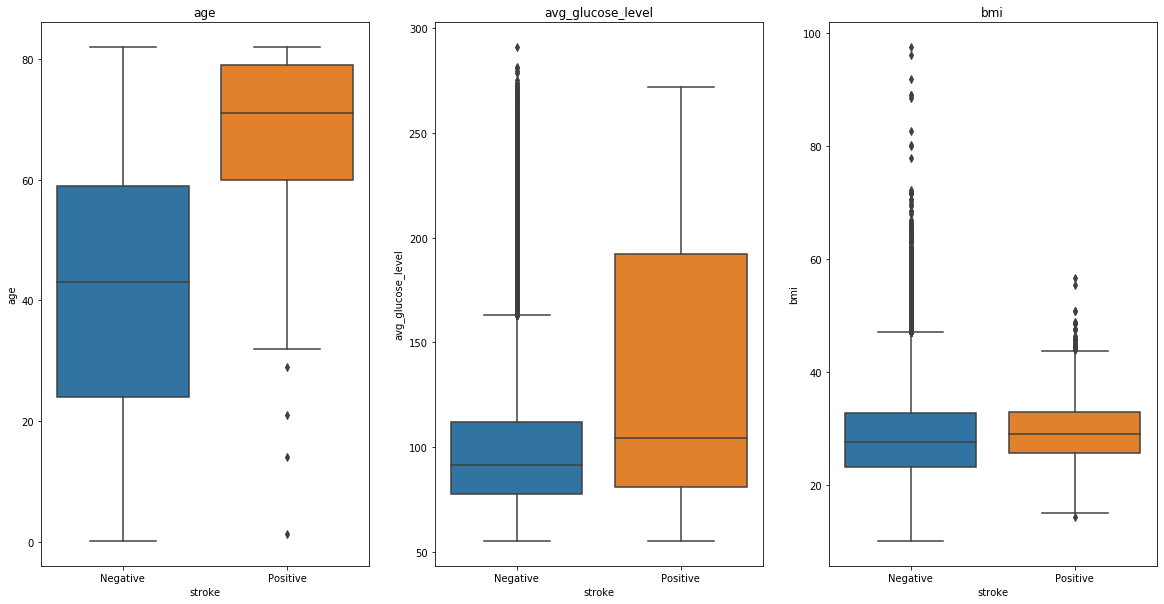

In [6]:
f, axes= plt.subplots(1, 3, figsize = (20, 10))
sns.boxplot(x="stroke", y="age", data =df, ax=axes[0]).set_title('age')
sns.boxplot(x="stroke", y="avg_glucose_level", data =df, ax=axes[1]).set_title('avg_glucose_level')
sns.boxplot(x="stroke", y="bmi", data =df, ax=axes[2]).set_title('bmi')
plt.show()

# menghapus outlier bmi

In [7]:
def removeOutlier(df, col_name, threshold, upper=True):
    if(upper==True):
        df = df.drop(df[(df[col_name] > threshold)].index)
    else:
        df = df.drop(df[(df[col_name] < threshold)].index)
    return df
    
df = removeOutlier(df, 'bmi', 77)
df = df.reset_index()
df = df.drop(columns=['index'])
df = df.drop(columns=['id'])

In [8]:
df.describe()

,age,avg_glucose_level,bmi
count,43390.000000,43390.000000,41928.000000
mean,42.219995,104.481528,28.591030
std,22.519985,43.107079,7.717157
min,0.080000,55.000000,10.100000
25%,24.000000,77.540000,23.200000
50%,44.000000,91.580000,27.700000
75%,60.000000,112.067500,32.800000
max,82.000000,291.050000,72.200000


# Dealing with Null values

In [9]:
df.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13287
stroke                   0
dtype: int64

fill missing values of bmi to its mean

In [10]:
bmi_avg = np.mean(df['bmi'])
values = {'bmi': bmi_avg}
df = df.fillna(value=values)

People under 15 year old are considered as 'never smoked'

In [11]:
df['smoking_status'] = df.apply(
    lambda row: 'never smoked' if (pd.isnull(row['smoking_status']) and row['age'] < 15) else row['smoking_status'],
    axis=1
)

The rest of the missing values are considered as 'not answered'

In [12]:
df.smoking_status.fillna('not answered',inplace=True)

# Scaling

In [13]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['age'] = scaler.fit_transform(df['age'].values.reshape(-1,1))
df['avg_glucose_level'] = scaler.fit_transform(df['avg_glucose_level'].values.reshape(-1,1))
df['bmi'] = scaler.fit_transform(df['bmi'].values.reshape(-1,1))

# Convert categorical values to numeric

In [14]:
gender = {'Male': 0, 'Female': 1, 'Other': 2}
hypertension = {'Negative': 0, 'Positive': 1}
heart_disease = {'Negative': 0, 'Positive': 1}
ever_married = {'No': 0, 'Yes': 1}
work_type = {'children': 0, 'Govt_job': 1, 'Never_worked': 2, 'Private': 3, 'Self-employed': 4}
residence_type = {'Rural': 0, 'Urban': 1}
smoking_status = {'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'not answered': 3}

df['gender'] = df['gender'].map(gender)
df['hypertension'] = df['hypertension'].map(hypertension)
df['heart_disease'] = df['heart_disease'].map(heart_disease)
df['ever_married'] = df['ever_married'].map(ever_married)
df['Residence_type'] = df['Residence_type'].map(residence_type)
df['work_type'] = df['work_type'].map(work_type)
df['smoking_status'] = df['smoking_status'].map(smoking_status)

In [15]:
df.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
count,43390.000000,43390.000000,43390.000000,43390.000000,43390.000000,43390.000000,43390.000000,43390.000000,43390.000000,43390.000000
mean,0.591888,-0.049445,0.093455,0.047522,0.643789,2.476216,0.501291,0.373660,0.053373,1.337543
std,0.492005,0.625555,0.291072,0.212756,0.478884,1.290119,0.500004,1.248485,0.824568,0.963344
min,0.000000,-1.220000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.059445,-1.956522,0.000000
25%,0.000000,-0.555556,0.000000,0.000000,0.000000,1.000000,0.000000,-0.406632,-0.510870,1.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,0.444444,0.000000,0.000000,1.000000,3.000000,1.000000,0.593368,0.489130,2.000000
max,2.000000,1.055556,1.000000,1.000000,1.000000,4.000000,1.000000,5.777134,4.793478,3.000000


# Initialize Model

In [16]:
# Classifier

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Oversampling
from imblearn.over_sampling import RandomOverSampler
# Undersampling
from imblearn.under_sampling import RandomUnderSampler


In [17]:
mlp = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(24,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=seed, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
dt = DecisionTreeClassifier()

# Oversample dataset

In [18]:
X = df
y = X.pop('stroke')

X_res , y_res = RandomOverSampler().fit_resample(X, y)

# Fit Model

In [19]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

train_acc = []
test_acc = []
for train_index, test_index in skf.split(X_res, y_res):
    model = mlp
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res[train_index], y_res[test_index]

    model.fit(X_train, y_train)

    trainScore = model.score(X_train, y_train)
    testScore = model.score(X_test, y_test)
    
    train_acc.append(trainScore)
    test_acc.append(testScore)

In [20]:
train_acc


[0.823150606562908,
 0.8275953117894705,
 0.8204075046574056,
 0.8262310953337929,
 0.8338467405973127]

In [21]:
test_acc

[0.8213342721351875,
 0.8213929472510708,
 0.8181658158774864,
 0.8216863228304876,
 0.8263114657904002]

In [22]:
test_sample = np.array(X_test.loc[3]).reshape(1, -1) # ambil sampel ke 3 di X_test
test_sample

array([[ 1.        ,  0.72222222,  0.        ,  0.        ,  1.        ,
         3.        ,  0.        , -0.65281298,  0.84782609,  0.        ]])

In [23]:
model.predict_proba(test_sample) # probability of negative and positive stroke

array([[0.62127243, 0.37872757]])